In [68]:
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
import sys
sys.path.append(r'D:\kasia\tracking\E6_exp\code\tracks_interactions')
from tracks_interactions.db.db_model import NO_PARENT, CellDB, TrackDB
import dask.array as da
import napari
import numpy as np
import os
os.environ['NAPARI_PERFMON'] = '0'
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
# get access to the database
db_path = r'D:\kasia\tracking\E6_exp\double_segmentation_ultrack\Exp6_gardener_example_to_process.db'
engine = create_engine(f'sqlite:///{db_path}')
session = sessionmaker(bind=engine)()

from sqlalchemy import text
session.execute(text("ANALYZE;"))
session.commit()

In [3]:
t=session.query(TrackDB).filter(TrackDB.accepted_tag == True).all()

In [6]:
cells=session.query(CellDB).filter_by(track_id = t[0].track_id).order_by(CellDB.t).all()
cells[0].signals

{'area': 252,
 'ch0_nuc': 3953.1825396825398,
 'ch0_cyto': 2443.0997229916898,
 'ch1_nuc': 1865.5833333333333,
 'ch1_cyto': 273.33240997229916}

In [19]:
signals = []
tag_list = []
for cell_num in range(len(t)):

    # find cell id
    track_id = t[cell_num].track_id

    # get all cells from the track
    cells=session.query(CellDB).filter_by(track_id = track_id).order_by(CellDB.t).all()

    tag = ''
    for cell in cells:
        if cell.tags.get('apoptosis', False):
            tag='_apo'
            break
        if cell.tags.get('mitosis', False):
            tag='_mit'
            break
    

    # get signal
    s = []
    for cell in cells:
        s.append(cell.signals['ch0_cyto']/cell.signals['ch0_nuc'])
    s = np.array(s)

    if len(s) > 50:
        signals.append(s)
        tag_list.append(tag)

In [21]:
max_len = 0
for s in signals:
    max_len = max(max_len, len(s))
print(max_len)

240


In [22]:
signals_apo = [signals[i] for i in range(len(signals)) if tag_list[i] == '_apo']   
print(len(signals_apo))
signals_senes = [signals[i] for i in range(len(signals)) if tag_list[i] == '']
print(len(signals_senes))

9
7


In [33]:
# make a 2D array
signals2D = np.zeros((len(signals_apo)+len(signals_senes), max_len))

i = 0
for s in signals_apo:
    start_index = max_len - len(s)  
    signals2D[i, start_index:] = s
    #signals2D[i, :len(s)] = s
    i+=1

for s in signals_senes:
    start_index = max_len - len(s)  
    signals2D[i, start_index:] = s
    #signals2D[i, :len(s)] = s
    i+=1

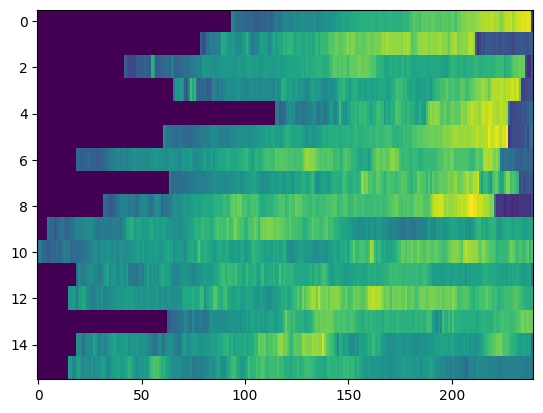

In [34]:
# create a heatmap with matplotlib
plt.imshow(signals2D, aspect='auto', cmap='viridis',interpolation='nearest')


In [82]:
# data cleaning
signals_apo_cut = []
for s in signals_apo:
    st  = len(s)/2
    for i in range(int(st), len(s)-2):
        if s[i]-s[i+1] > 0.5:
            print(f'{i} from apo cut')
            break
    s = s[:i]
    signals_apo_cut.append(s)

signals_senes_cut = []
for s in signals_senes:
    st  = len(s)/2
    for i in range(int(st), len(s)-2):
        if s[i]-s[i+1] > 0.5:
            print(f'{i} from senes cut')
            break
    s = s[:i]
    signals_senes_cut.append(s)


132 from apo cut
193 from apo cut
167 from apo cut
112 from apo cut
166 from apo cut
204 from apo cut
168 from apo cut
188 from apo cut


In [83]:
# make a 2D array
signals2D_cut = np.zeros((len(signals_apo)+len(signals_senes), max_len))

i = 0
for s in signals_apo_cut:
    start_index = max_len - len(s)  
    signals2D_cut[i, start_index:] = s
    i+=1

for s in signals_senes:
    start_index = max_len - len(s)  
    signals2D_cut[i, start_index:] = s
    i+=1

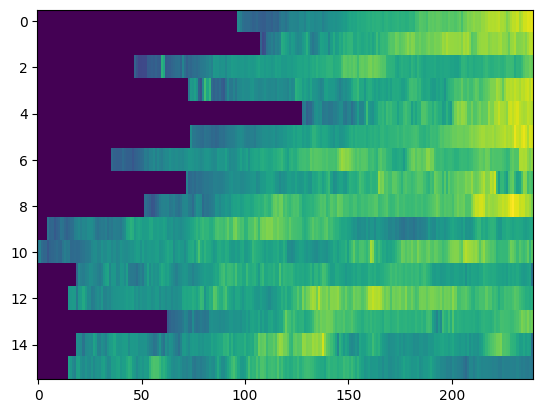

In [84]:
# create a heatmap with matplotlib
plt.imshow(signals2D_cut, aspect='auto', cmap='viridis',interpolation='nearest')

In [85]:
# compare mean of last 5 frames
mean_apo = [np.mean(s[-5:]) for s in signals_apo_cut]
mean_senes = [np.mean(s[-5:]) for s in signals_senes]

In [86]:
df_apo = pd.DataFrame(mean_apo,columns=['mean'])
df_apo['condition']='apo'
df_senes = pd.DataFrame(mean_senes,columns=['mean'])
df_senes['condition']='senes'
df = pd.concat([df_apo, df_senes],ignore_index=True)

In [87]:
df

,mean,condition
0,1.541781,apo
1,1.403236,apo
2,1.236367,apo
3,1.491209,apo
4,1.444837,apo
5,1.517362,apo
6,1.375064,apo
7,1.228512,apo
8,1.408670,apo
9,0.944494,senes


<Axes: xlabel='condition', ylabel='mean'>

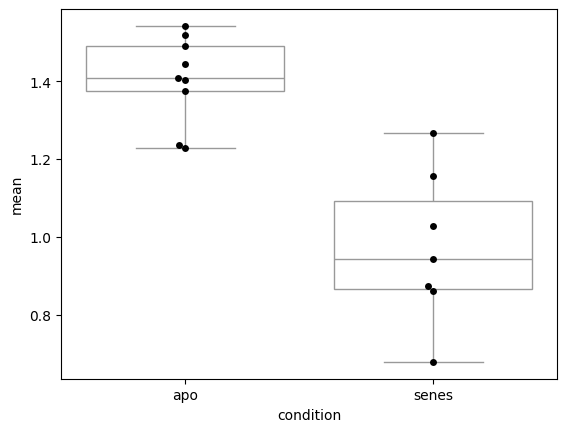

In [88]:
sns.boxplot(data=df, x='condition', y='mean',color='white')
sns.swarmplot(data=df, x='condition', y='mean',color='black')

In [89]:
from scipy.stats import ttest_ind
ttest_ind(mean_apo, mean_senes)

TtestResult(statistic=5.564864099156044, pvalue=6.968229185121256e-05, df=14.0)